### Gaussian Processes
- Generic supervised method
- Returns a probabilistic (Gaussian) prediction - this enables building confidence intervals.
- A range of kernels - both standard and custom - can be used.
- Gaussians lose efficiency in high-D spaces (when #features > a few dozen).

### [Gaussian Process Regression (GPR)](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor)
- The *prior* of a Gaussian Process* needs to be specified. 
    - The mean can be constant & zero (`normalize_y=False`) or derived from training data (`normalize_y=True`).
    - The covariance is specified by passing a [kernel object](https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels); the kernel's parameters are optimized during fitting by maximizing the **log-marginal-likelihood (LML)** of the `optimizer`.
    - LML can have *multiple local optima* - you can restart the optimizer with `n_restarts_optimizer`.
    - The 1st run uses the kernel's initial parameter values.
    - Subsequent runs use parameters randomly chosen from a range of allowed values, or kept constant if the optimizer is specified as `None`. 

- Target noise is specified using `alpha` - either globally or as per datapoint.

### Example: GPR with noise-level estimate
- Demonstrates how GPR with a sum kernel can estimate noise level in a dataset.
- Two local LML maxima exist:
    - The 1st corresponds to a model with high noise & large length scale.
    - The 2nd has a smaller noise level and short length scale, which explains most variation by the noise-free function.
    - It is important repeat the optimization multiple times with different initial values.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK

In [2]:
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5*np.sin(3*X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

In [3]:
# First run
plt.figure()

kernel = 1.0 * RBF(
    length_scale=100.0, 
    length_scale_bounds=(1e-2, 1e3)) + WK(
        noise_level=1, 
        noise_level_bounds=(1e-10, 1e+1))

gp = GPR(kernel=kernel,
         alpha=0.0).fit(X, y)

X_            = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


<Figure size 432x288 with 0 Axes>

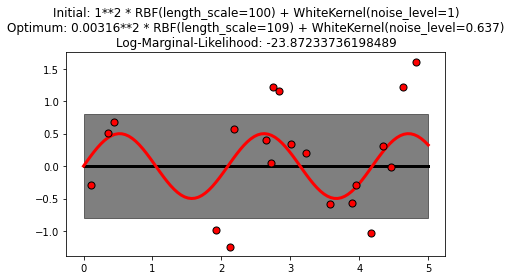

In [4]:
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()


In [6]:
# Second run
kernel = 1.0*RBF(length_scale=1.0, 
                 length_scale_bounds=(1e-2, 1e3)) + WK(
                    noise_level=1e-5, 
                    noise_level_bounds=(1e-10, 1e+1))

gp = GPR(kernel=kernel,
         alpha=0.0).fit(X, y)

X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

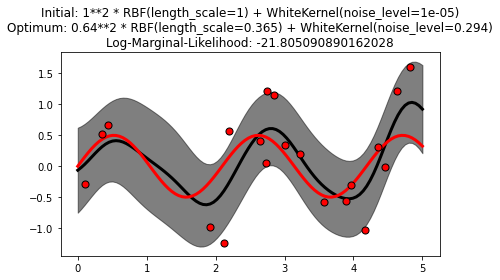

In [7]:
plt.figure()

plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

In [8]:
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)

LML = [[gp.log_marginal_likelihood(
            np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]

LML = np.array(LML).T

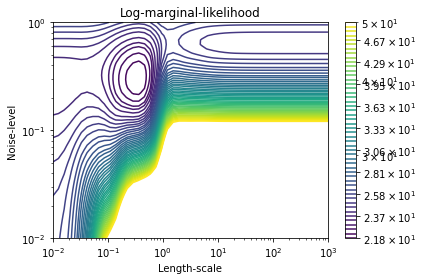

In [9]:
# Plot LML landscape
plt.figure()
vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50

level = np.around(
    np.logspace(np.log10(vmin), 
                np.log10(vmax), 50), 
    decimals=1)

plt.contour(Theta0, Theta1, -LML,
            levels=level, 
            norm=LogNorm(vmin=vmin, 
                         vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

### GPR vs Kernel Ridge Regression
- GPR and KRR learn target functions by using "the kernel trick".
- KRR learns a linear function, induced by a kernel, that corresponds to a non-linear function in the original space. The linear function is chosen based on MSE (mean squared error) loss with ridge regularization.
- GPR uses the kernel to find the covariance of the prior distribution over the target functions, and uses the training data to find a likelihood function.
- A Gaussian posterior distribution is then defined using Bayes theorem. the distribution's mean is used for predictions.

- GPR can choose a kernel's parameters vias gradient ascent of the marginal likelihood function - KRR needs to do a grid search on a cross-validated MSE (mean squared loss) function.
- GPR learns a probabilistic model of the target function, therefore can provide confidence intervals. KRR can only provide predictions.